<a href="https://colab.research.google.com/github/PabloKarpacho/Lab1/blob/main/%D0%BB%D0%B0%D0%B1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
import scipy.stats
from sklearn.mixture import GaussianMixture
from scipy.optimize import least_squares

# Пути к используемым файлам

In [2]:
#fp = 'C:/Users/karpo/Downloads/EXPORT.xlsx' #Ноут путь к датасету
fp = 'C:/Users/Павел/Downloads/Telegram Desktop/данные/данные/EXPORT.xlsx' #ПК путь к датасету
#cont_distr_p = 'C:/Users/karpo/Downloads/Nepreryvnye_raspredelenia.xlsx' # Файл с названием непрерывных распределений из scipy.stats
cont_distr_p = 'D:/Работы/Непрерывные распределения.xlsx'

# Препроцессинг

In [3]:
data = pd.read_excel(fp)
drop_cols = ['Гр.зак.', 'Дата поставки по приложению',
       'ПервоначДатаПоставки (план МТО)', 'Кол-во к закупу, АЕИ',
       'Код класса МТР', 'Дата заявки', 'Дата приложения', 'Срок поставки',
        'Шаг корр. ЭСД',
       'Шаг ЭСД', 'ПервоначДатаУтвПлМТО', 'Кол-во в предв. СФ, АЕИ',
       'Сумма по Сч/ф с НДС (поставлено)', 'Поступило на ЦС, АЕИ',
       
       'Сумма (незаконтрактовано) с НДС',
       'Сумма ПлЦ законтракт/непоставл с НДС', 'Курс1', 'Курс3',
       'Курс5','Статус плана МТО', 'Кол-во в Заказах, АЕИ', 'Клиент', 'СПП элемент','Тип финансирования', 'Сумма заказов с НДС','Тонаж по планам МТО', 'Рекв.Грузополучателя','Дата Сч/ф','Кол-во в СФ, АЕИ', 'Курс4']

data.drop_duplicates(subset=['Дата ФП по последней входящей поставке','Дата заявки', 'Поставщик'], inplace=True, ignore_index=True)

data.drop(drop_cols, axis = 1 ,inplace = True)

a = []
for i in range(len(data['Дата ФП по последней входящей поставке'])):
  if data['Дата ФП по последней входящей поставке'][i] > data['Прогнозная дата поставки'][i]:
    period = data['Дата ФП по последней входящей поставке'][i] - data['Прогнозная дата поставки'][i]
    a.append(period.days)
  else:
    period = data['Прогнозная дата поставки'][i] - data['Дата ФП по последней входящей поставке'][i]
    a.append(-abs(period.days))
data['Задержка поставки'] = a

data.sort_values(by = 'Прогнозная дата поставки', ignore_index= True, inplace = True)
data.drop([0,1,2,3,4,5,6], axis = 0 ,inplace = True)
data.fillna(0, inplace=True)
data.reset_index(drop=True,inplace=True)

data['План.сумма с НДС 18%'] = np.log(data['План.сумма с НДС 18%'])
data

,Материал,Поставщик,План.сумма с НДС 18%,Прогнозная дата поставки,Дата ФП по последней входящей поставке,Курс2,Задержка поставки
0,770000495396,11926,11.678440,2018-09-30,2019-07-17,65.92350,290
1,770000495392,69072,12.594731,2018-12-31,2020-04-07,62.79770,463
2,770000691011,75267,9.327784,2019-08-31,2020-04-16,62.24990,229
3,770000691007,68082,10.248820,2019-08-31,2020-04-16,62.24990,229
4,770000636916,8863,18.307538,2019-10-31,2020-06-05,76.25620,218
...,...,...,...,...,...,...,...
235,770000981189,63684,13.682229,2021-09-30,2021-06-18,73.65670,-104
236,770000981195,63684,13.387839,2021-09-30,2021-06-22,73.65670,-100
237,770001010193,63684,14.426440,2021-12-30,2021-06-21,75.79315,-192
238,770001010112,63684,11.880985,2021-12-30,2021-06-18,75.79315,-195


#Оценка порядковой статистики

In [4]:
cont_cols = ['Курс2','Задержка поставки', 'План.сумма с НДС 18%'	] # Колонки с анализируемыми непрерывными СВ

In [5]:
data[cont_cols].describe() 

,Курс2,Задержка поставки,План.сумма с НДС 18%
count,240.000000,240.000000,240.000000
mean,69.460232,69.829167,13.172019
std,4.997075,125.733397,2.836404
min,61.105300,-341.000000,3.461351
25%,63.972200,-3.250000,11.280553
50%,69.752400,27.000000,13.330053
75%,73.682375,139.500000,15.196009
max,80.881500,520.000000,19.360839


# Построение непараметрической оценки PDF в виде гистограммы и использование функции плотности ядра

In [6]:
  m = round(5*np.log10(len(data["Задержка поставки"]))) # Оценка колиичества бинов для гистограмм
  m

12

Построение гистограмм и ядерных оценок плотности

C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wit

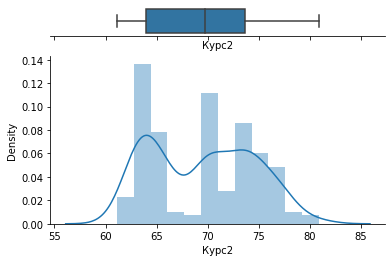

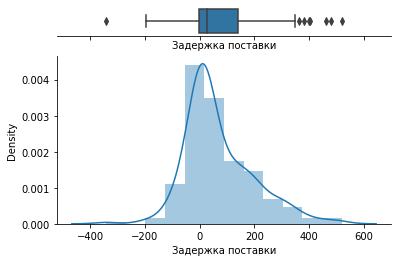

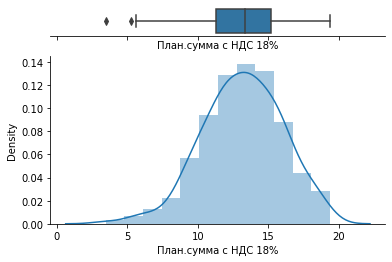

In [7]:
for col in cont_cols:
  x = data[col]
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                      gridspec_kw={"height_ratios": (.15, .85)})

  sns.boxplot(x, ax=ax_box)
  sns.distplot(x,bins=m, ax=ax_hist)

  ax_box.set(yticks=[])
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)

#Поиск распределения 

Функция для подсчёта pvalue теста Колмогорова-Смирнова

In [8]:
def KS(column, dist, data):

  attr = getattr(scipy.stats._continuous_distns, dist)

  values = plt.hist(data[column],density=True, label='Распределение колонки')
  x_axis = np.linspace(np.min(data[column]), np.max(data[column]))

  params = attr.fit(data[column])
  ks = scipy.stats.kstest(data[column], dist, params, N=100)
  pdf = attr.pdf(x_axis, *params)

  return(ks.pvalue)

Функция для нахождения лучшего распределения по максимальному значению pvalue теста Колмогорова-Смирнова

In [9]:
def best_cont_dist(column,data,dist_list):  

  p_value = []
  for item in dist_list['Название']:

    try:
      p_value.append(KS(column, item, data))
    except:
      p_value.append(np.nan)
      continue

  dist_list['Pvalue'] = p_value
  dist_list = dist_list[dist_list['Pvalue'] == max(p_value)]
  dist_list.reset_index(drop=True,inplace=True)
  best_dist = {'Название' : dist_list['Название'][0],
              'pvalue' : dist_list['Pvalue'][0]}
  return(best_dist)

# Params

Определения лучшего распределения для каждой из колонок

In [ ]:
cont_distr = pd.read_excel(cont_distr_p)
params1 = best_cont_dist('Задержка поставки',data,cont_distr)

In [12]:
params1

{'Название': 'norminvgauss', 'pvalue': 0.2936173082337127}

In [ ]:
params2 = best_cont_dist('Курс2',data,cont_distr)

In [14]:
params2

{'Название': 'bradford', 'pvalue': 0.010715377619294501}

In [ ]:
params3 = best_cont_dist('План.сумма с НДС 18%',data,cont_distr)

In [16]:
params3

{'Название': 'genextreme', 'pvalue': 0.9975064252143077}

# Нахождение параметра распределение и его построение


Обучения распределения и получение его параметров 

In [17]:
def dist_params(column, params, data):
  dist = params['Название']
  attr = getattr(scipy.stats._continuous_distns, dist)

  x_axis = np.linspace(np.min(data[column]), np.max(data[column]))

  params_1 = attr.fit(data[column])
  pdf1 = attr.pdf(x_axis, *params_1)

  return(params_1)

Функция для построения функции плотности вероятности PDF

In [18]:

def dist_plot(column, params, data, params_ML, params_MNK):
  dist = params['Название']
  attr = getattr(scipy.stats._continuous_distns, dist)


  plt.figure(figsize=(10, 5))
  values = plt.hist(data[column],density=True, label='Распределение колонки', bins = m)
  x_axis = np.linspace(np.min(data[column]), np.max(data[column]))

  params_1 = params_ML
  pdf1 = attr.pdf(x_axis, *params_1)

  params_2 = params_MNK
  pdf2 = attr.pdf(x_axis, *params_2)

  plt.title(str(column))
  plt.plot(x_axis, pdf1, label='Эмпирическое распределение МП')
  plt.plot(x_axis, pdf2, label='Эмпирическое распределение МНК')
  plt.legend()
  plt.show()


# Задержка поставки

In [19]:
zp = dist_params('Задержка поставки', params1,data)
zp

(0.7966156528024042, 0.5402603588700938, -4.236322884639751, 80.25637988727178)

In [20]:

x0 = np.array(zp)
def LS(x):
  list_quan = np.arange(0,1,0.05)

  xdata = np.quantile(data['Задержка поставки'], list_quan)[1:]

  diff = abs((scipy.stats.norminvgauss.ppf(list_quan, x[0], x[1], x[2], x[3])[1:]) - xdata).sum()
  return diff
  
res_zp = least_squares(LS, x0)
res_zp.x

array([ 0.78553011,  0.55908463, -4.23623627, 80.25646786])

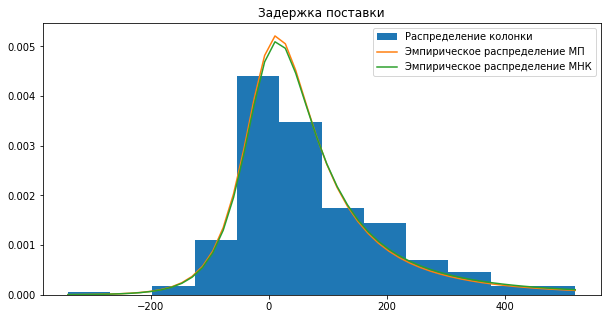

In [21]:
dist_plot('Задержка поставки', params1,data, zp, res_zp.x)

# Курс2

In [22]:
k2 = dist_params('Курс2', params2, data)
k2

(1.187483315627583, 61.105299066768765, 19.77620093448902)

In [23]:
x0 = np.array(k2)
list_quan = np.arange(0,1,0.05)
xdata = np.quantile(data['Курс2'], list_quan)[1:]

def datax(x):
  return xdata

def LS(a,b,c):
  return scipy.stats.bradford.ppf(list_quan,a,b,c)[1:]

def func1(x):
  return (LS(x[0], x[1], x[2]) - datax(x[0]))
res_k2 = least_squares(func1, x0)

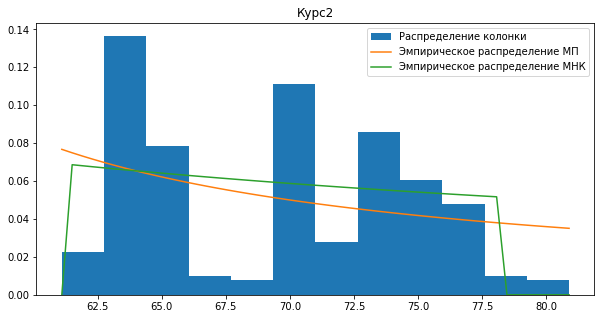

In [24]:
dist_plot('Курс2', params2,data, k2, res_k2.x)

# План.сумма с НДС 18%

In [25]:
nds = dist_params('План.сумма с НДС 18%', params3, data)

In [26]:
nds

(0.3736930342178807, 12.297313812555254, 2.963932643599045)

In [27]:

x0 = np.array(nds)
list_quan = np.arange(0,1,0.05)
xdata = np.quantile(data['План.сумма с НДС 18%'], list_quan)[1:]

def datax(x):
  return xdata

def LS(a,b,c):
  return scipy.stats.genextreme.ppf(list_quan,a,b,c)[1:]

def func1(x):
  return (LS(x[0], x[1], x[2]) - datax(x[0]))
res_nds = least_squares(func1, x0)

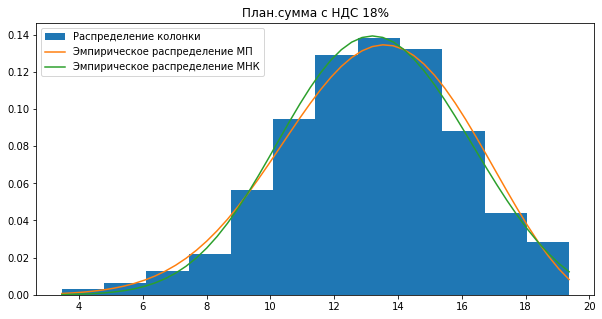

In [28]:

dist_plot('План.сумма с НДС 18%', params3,data, nds, res_nds.x)


# Q-Q plots


Построение квантильных (биплотов распределение СВ - плотность вероятности эмпиирического распределения)

In [29]:
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution
def quantile_biplot(column ,params, data,params_ML, params_MNK):
  distr = params['Название']
  attr = getattr(scipy.stats._continuous_distns, distr)
  # Calculation of quantiles
  percs = np.linspace(0, 100, 21)
  qn_first = np.percentile(data[column], percs)
  params_ML = params_ML
  qn_distr__ML  = attr.ppf(percs / 100.0, *params_ML)

  params_MNK = params_MNK
  qn_distr__MNK  = attr.ppf(percs / 100.0, *params_MNK)

  # Building a quantile biplot
  x = np.linspace(np.min(data[column]), np.max(data[column]))
  plt.figure(figsize=(10, 10))
  plt.plot(qn_first, qn_distr__ML, ls="", marker="o", markersize=6, label = 'ML')
  plt.plot(qn_first, qn_distr__MNK, ls="", marker="o", markersize=6, label = 'LSM')
  plt.plot(x, x, color="k", ls="--")

  plt.xlabel(f'Empirical distribution')
  plt.ylabel('Theoretical '+ str(distr) +' distribution')
  plt.title('Биплот для колонки ' + str(column))
  plt.legend()
  plt.show()

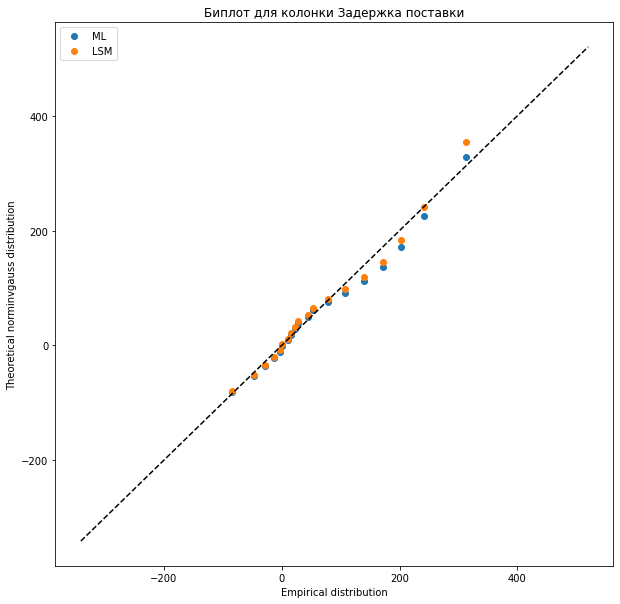

In [30]:
quantile_biplot('Задержка поставки', params1,data, zp, res_zp.x)

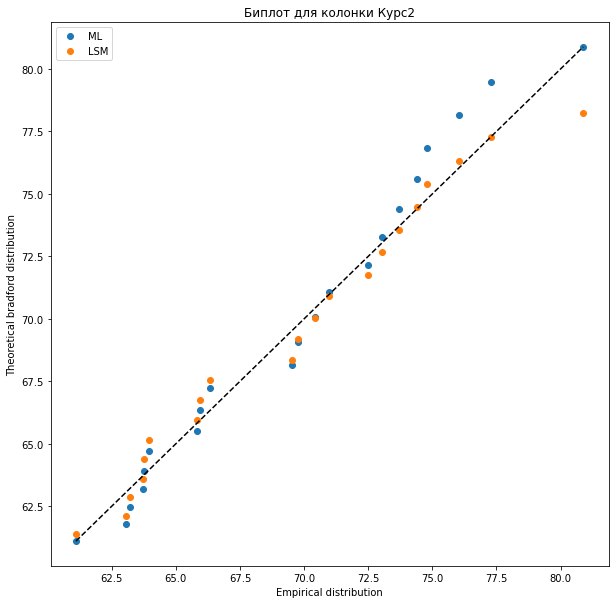

In [31]:
quantile_biplot('Курс2', params2,data, k2, res_k2.x)

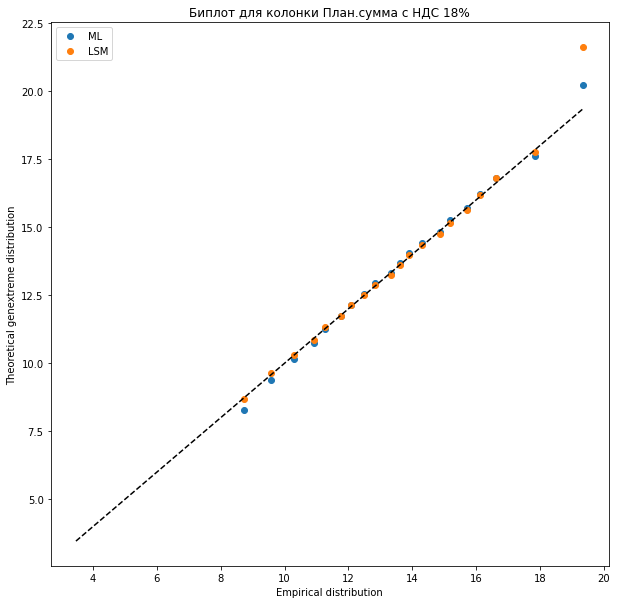

In [32]:

quantile_biplot('План.сумма с НДС 18%', params3,data, nds, res_nds.x)

# Моделирование смеси распределений Гаусса

In [33]:
def mixture(collname, n_components):

  samples = np.array(data[collname])

  # Fit GMM
  gmm = GaussianMixture(n_components=n_components, covariance_type="full", tol=0.001, random_state = 42)
  gmm = gmm.fit(X=np.expand_dims(samples, 1))

  preds = gmm.predict(X=np.expand_dims(samples, 1))
  
  return(preds)


Функция подбора Гауссовых распределений в смеси для n компонент

In [34]:
def Mixture_ktest(collname, n_components, info):
  mix_distr = pd.DataFrame()
  mix_distr[collname] = data[collname]
  mix_distr['Group'] = info
  ks_ar = []
  means_ar = []
  disps_ar = []
  gmm_x = np.linspace(np.min(data[collname]), np.max(data[collname]))
  
  hist_values = plt.hist(data[collname], bins=m, density=True, alpha=0.5, color="#0070FF")
  for n in range(n_components):
    gropped = mix_distr.groupby(by='Group').get_group(n)
    params = scipy.stats.norm.fit(gropped[collname])
    ks = scipy.stats.kstest(gropped[collname], 'norm', params, N=100)

    ks_ar.append(ks.pvalue)
    means_ar.append(params[0])
    disps_ar.append(params[1])
    gmm_y = scipy.stats.norm.pdf(gmm_x, *params)
    plt.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

  info_pd = pd.DataFrame()
  info_pd['means'] =  means_ar
  info_pd['disps'] =  disps_ar
  info_pd['pvalue'] = ks_ar

  plt.title(collname)
  plt.xlabel('Values')
  plt.ylabel('Probabilities')

  return(info_pd)

,means,disps,pvalue
0,73.111914,2.864118,0.010864
1,64.169020,1.301193,0.002269


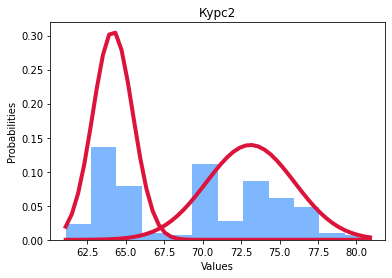

In [35]:
n = 2
info = mixture('Курс2',n)
Mixture_ktest('Курс2', n, info)

Функция группировки значений СВ по кластерам

In [36]:

def group(collname, n):
  mix_distr = pd.DataFrame()
  mix_distr[collname] = data[collname]
  mix_distr['Group'] = info
  grooped = mix_distr.groupby(by='Group').get_group(n)
  return(grooped)


Параметры новых распределений для класетров

C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:851: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:855: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:3077: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 26.25.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:3077: RuntimeWarning: The shape parameter of the erlang distribution has been 

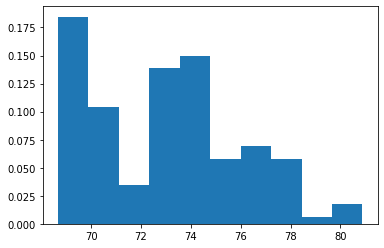

In [37]:
option0 = best_cont_dist('Курс2', group('Курс2',0), cont_distr)

In [38]:
option0

{'Название': 'gengamma', 'pvalue': 0.1650493868184344}

In [39]:

params20 = dist_params('Курс2',option0,group('Курс2',0))
params20

(0.23012637976154587, 4.280889074480718, 68.67449980923959, 9.198998203230206)

Определение параметров распределения с помощью МНК

In [40]:
x0 = np.array(params20)
list_quan = np.arange(0,1,0.05)
xdata = np.quantile(group('Курс2',0)['Курс2'], list_quan)[1:]

def datax(x):
  return xdata

def LS(a,b,c,d):
  return scipy.stats.gengamma.ppf(list_quan,a,b,c,d)[1:]

def func1(x):
  return (LS(x[0], x[1], x[2],x[3]) - datax(x[0]))
res_k20 = least_squares(func1, x0)
res_k20.x

array([4.92447514e-03, 1.62182238e+02, 6.90126972e+01, 9.09812664e+00])

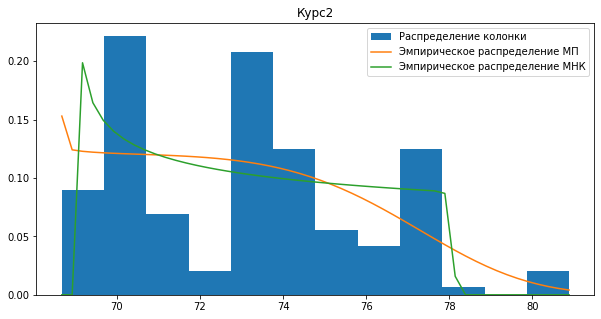

In [41]:
dist_plot('Курс2', option0, group('Курс2',0), params20, res_k20.x)

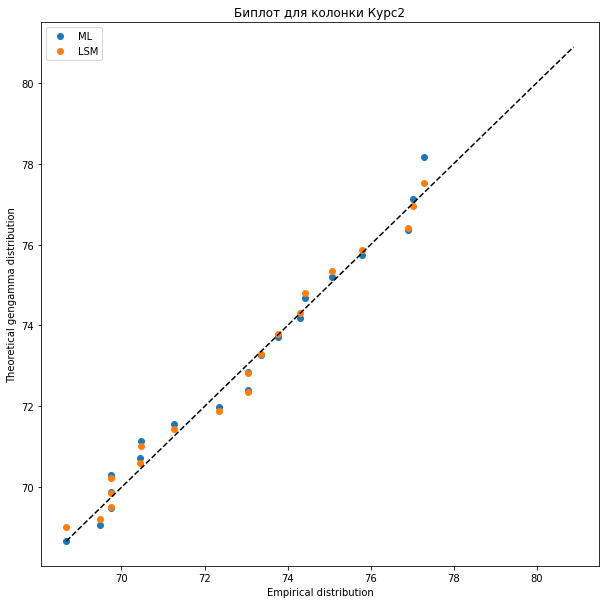

In [42]:
quantile_biplot('Курс2', option0, group('Курс2',0), params20, res_k20.x)

C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:851: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:855: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:3077: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 82.95.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:3077: RuntimeWarning: The shape parameter of the erlang distribution has been 

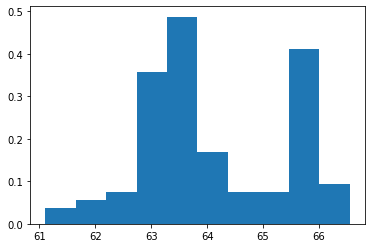

In [43]:
option1 = best_cont_dist('Курс2', group('Курс2',1), cont_distr)

In [44]:
option1

{'Название': 'moyal', 'pvalue': 0.10232006470943955}

In [45]:

params21 = dist_params('Курс2',option1,group('Курс2',1))
params21

(63.29633392604957, 0.7917838699587989)

In [46]:
x0 = np.array(params21)
list_quan = np.arange(0,1,0.05)
xdata = np.quantile(group('Курс2',1)['Курс2'], list_quan)[1:]

def datax(x):
  return xdata

def LS(a,b):
  return scipy.stats.moyal.ppf(list_quan,a,b)[1:]

def func1(x):
  return (LS(x[0], x[1]) - datax(x[0]))
res_k21 = least_squares(func1, x0)
res_k21.x

array([63.46259931,  0.62857802])

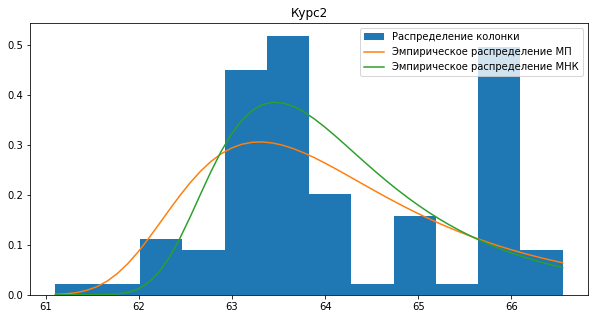

In [47]:
dist_plot('Курс2', option1, group('Курс2',1), params21, res_k21.x)

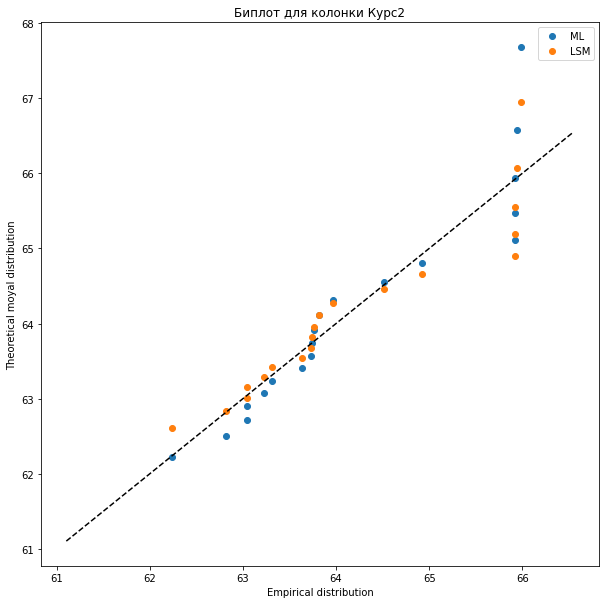

In [48]:
quantile_biplot('Курс2', option1, group('Курс2',1), params21, res_k21.x)

Построение полного распределения СВ "Курс2"

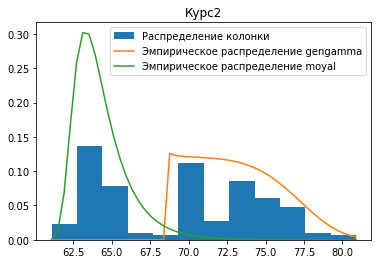

In [49]:
  column = 'Курс2'
  values = plt.hist(data[column],density=True, label='Распределение колонки', bins = m)
  x_axis = np.linspace(np.min(data[column]), np.max(data[column]))

  params0 = params20
  pdf0 = scipy.stats.gengamma.pdf(x_axis, *params0)

  params1 = params21
  pdf1 = scipy.stats.moyal.pdf(x_axis, *params1)

  plt.title(str(column))
  plt.plot(x_axis, pdf0, label='Эмпирическое распределение gengamma')
  plt.plot(x_axis, pdf1, label='Эмпирическое распределение moyal')
  plt.legend()
  plt.show()

# Критерий Крамера — Мизеса — Смирнова

In [50]:
def KMS(data, col, dist, params):
  x = data[col].values
  res = stats.cramervonmises(x, dist, params)
  return res

In [51]:
KMS(data, 'Задержка поставки', 'norminvgauss', zp)

CramerVonMisesResult(statistic=0.2260005787644915, pvalue=0.22233832988019997)

In [52]:
KMS(data, 'Курс2', 'bradford', k2)

CramerVonMisesResult(statistic=0.595864863360515, pvalue=0.022831380145334368)

In [53]:
KMS(data, 'План.сумма с НДС 18%', 'genextreme', nds)

CramerVonMisesResult(statistic=0.026618815824624963, pvalue=0.9860770017252242)

In [54]:

KMS(group('Курс2',0), 'Курс2', 'gengamma', params20)

CramerVonMisesResult(statistic=0.20166520553041165, pvalue=0.2644226544262409)

In [55]:

KMS(group('Курс2',1), 'Курс2', 'moyal', params21)

CramerVonMisesResult(statistic=0.34738600505689626, pvalue=0.09980734441987804)

# Сэмплирование

Сэмплирование методом SimpleRatioUniforms

In [118]:
def rejection_sampling(data, column, distibution, params, nbins):

  attr = getattr(scipy.stats._continuous_distns, distibution)
  x_axis = np.linspace(min(data[column]),max(data[column]))
  def _f(x):
    return(attr.pdf(x, *params))

  (a,b) = (min(data[column]),max(data[column]))

  def _g(x):
    return scipy.stats.uniform.pdf(x, loc=a, scale=b-a)

  M = 1.01*np.max(_f(x_axis)/_g(x_axis))

  X = []
  n = 10000
  for i in range(n):
    x = np.random.uniform(a,b)
    if _f(x)/(M*_g(x)) > np.random.uniform(0,1):
      X.append(x)
  plt.figure(figsize=(20,10))

  plt.plot(x_axis, _f(x_axis), label = ('Плотность эмпирического распределения '+ str(distibution)))
  plt.plot(x_axis, M*_g(x_axis), label = 'Плотность равномерного распределения')
  plt.hist(data[column], density=True, bins = nbins, label = 'Распределение СВ')
  plt.hist(X, density=True, alpha = 0.75, bins = nbins, label = 'Распределение сэмпла')
  plt.legend()
  plt.title('Cэмплирование ratio uniform методом ' + str(column))

Сэмплирование с помощью обратной функции

In [119]:
def sampling(data, column, distibution, params, nbins):

  x_axis = np.linspace(min(data[column]),max(data[column]))
  attr = getattr(scipy.stats._continuous_distns, distibution)

  y = attr.ppf(np.random.random_sample(1000), *params)
  plt.figure(figsize=(20,10))
  plt.xlim(min(data[column]), max(data[column]))
  plt.plot(x_axis, attr.pdf(x_axis, *params), label = ('Плотность эмпирического распределения '+ str(distibution)))
  plt.hist(data[column],density=True, label='Распределение колонки',bins = nbins)
  plt.hist(y,density=True, label='Распределение Сэмпла', bins = nbins, alpha=0.75)
  plt.legend()
  plt.title('Cэмплирование обратной функцией колонки ' + str(column))
  

# Графики сэмплов

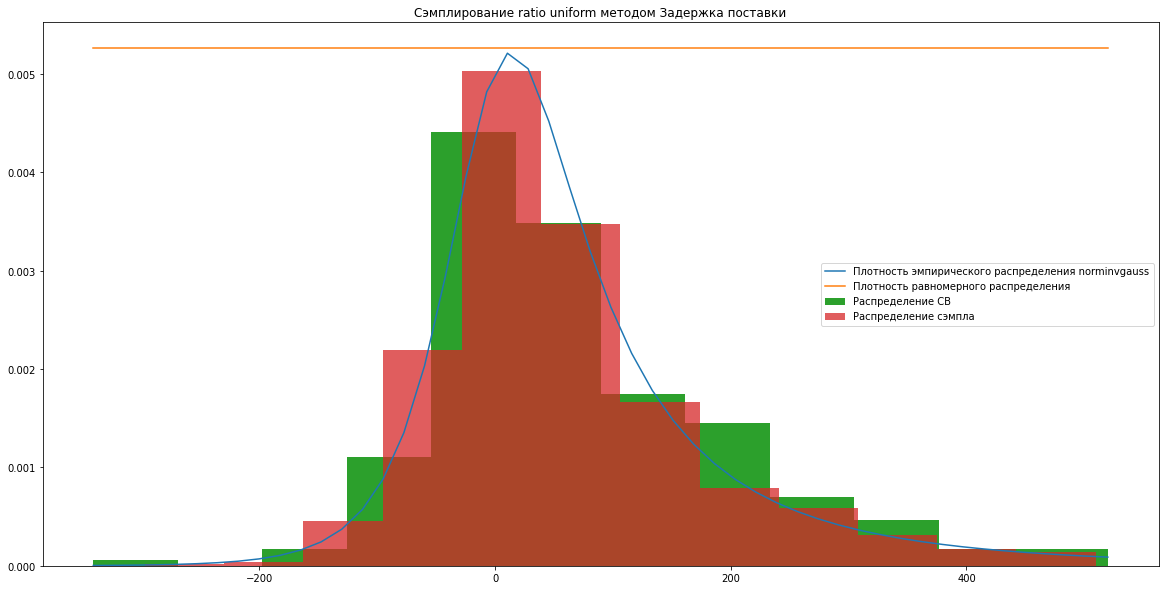

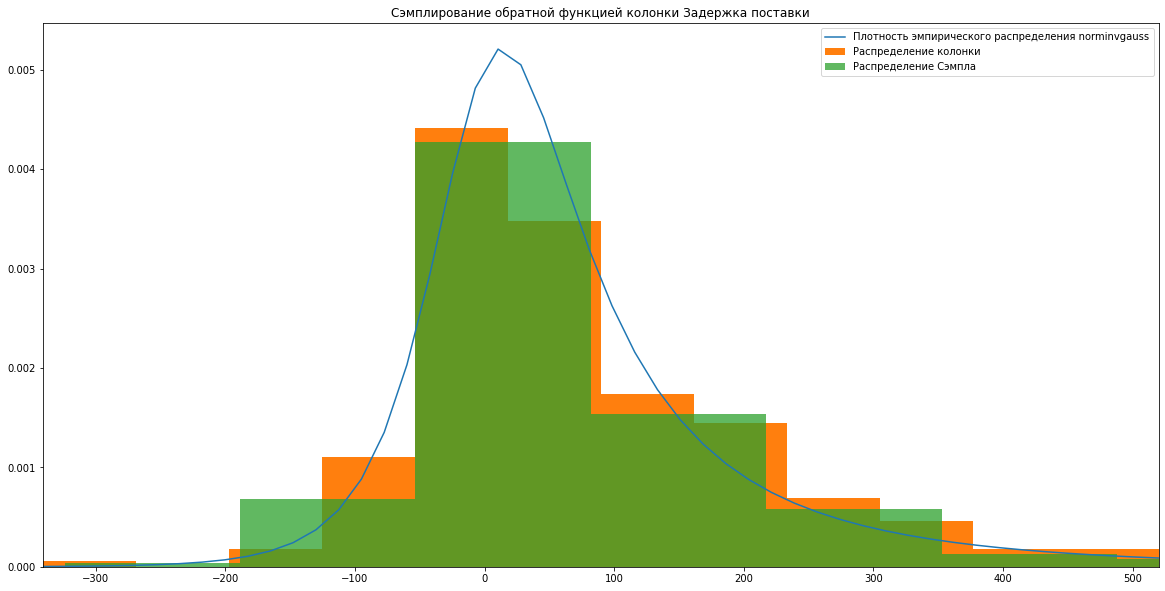

In [120]:
rejection_sampling(data, 'Задержка поставки', 'norminvgauss', zp,12)
sampling(data, 'Задержка поставки', 'norminvgauss', zp,12)

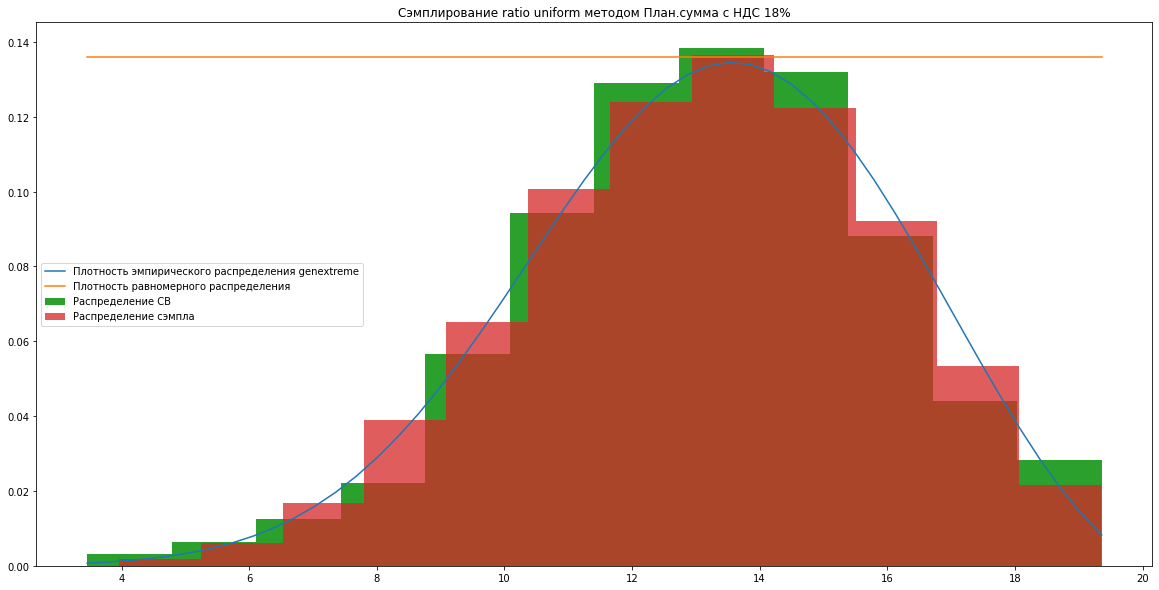

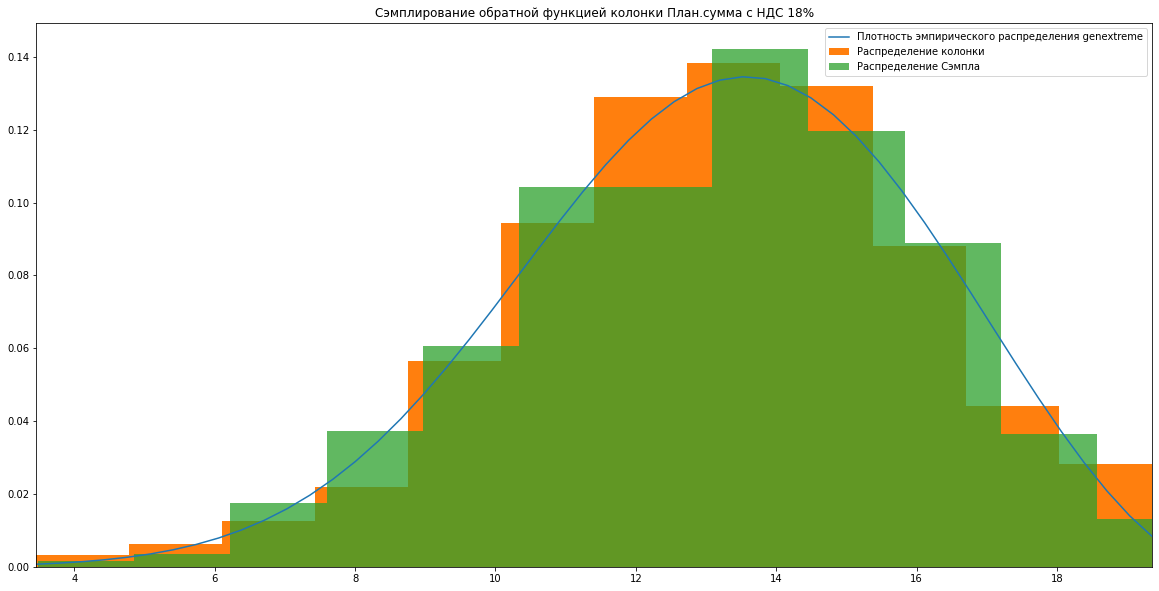

In [121]:
rejection_sampling(data, 'План.сумма с НДС 18%', 'genextreme', nds,12)
sampling(data, 'План.сумма с НДС 18%', 'genextreme', nds,12)

In [123]:
def rejection_sampling(data, column, distibution, params, nbins):

  attr = getattr(scipy.stats._continuous_distns, distibution)
  x_axis = np.linspace(min(data[column]),max(data[column]))
  def _f(x):
    return(attr.pdf(x, *params))

  (a,b) = (min(data[column]),max(data[column]))

  def _g(x):
    return scipy.stats.uniform.pdf(x, loc=a, scale=b-a)

  M = 1.01*np.max(_f(x_axis)/_g(x_axis))

  X = []
  n = 10000
  for i in range(n):
    x = np.random.uniform(a,b)
    if _f(x)/(M*_g(x)) > np.random.uniform(0,1):
      X.append(x)
  #plt.figure(figsize=(20,10))

  plt.plot(x_axis, _f(x_axis), label = ('Плотность эмпирического распределения '+ str(distibution)))
  plt.plot(x_axis, M*_g(x_axis), label = 'Плотность равномерного распределения')
  plt.hist(data[column], density=True, bins = nbins, label = 'Распределение СВ')
  plt.hist(X, density=True, alpha = 0.75, bins = nbins, label = 'Распределение сэмпла')
  plt.legend()
  plt.title('Cэмплирование ratio uniform методом ' + str(column))


def sampling(data, column, distibution, params, nbins):

  x_axis = np.linspace(min(data[column]),max(data[column]))
  attr = getattr(scipy.stats._continuous_distns, distibution)

  y = attr.ppf(np.random.random_sample(1000), *params)
  #plt.figure(figsize=(20,10))
  plt.xlim(min(data[column]), max(data[column]))
  plt.plot(x_axis, attr.pdf(x_axis, *params), label = ('Плотность эмпирического распределения '+ str(distibution)))
  plt.hist(data[column],density=True, label='Распределение колонки',bins = nbins)
  plt.hist(y,density=True, label='Распределение Сэмпла', bins = nbins, alpha=0.75)
  plt.legend()
  plt.title('Cэмплирование обратной функцией колонки ' + str(column))
  

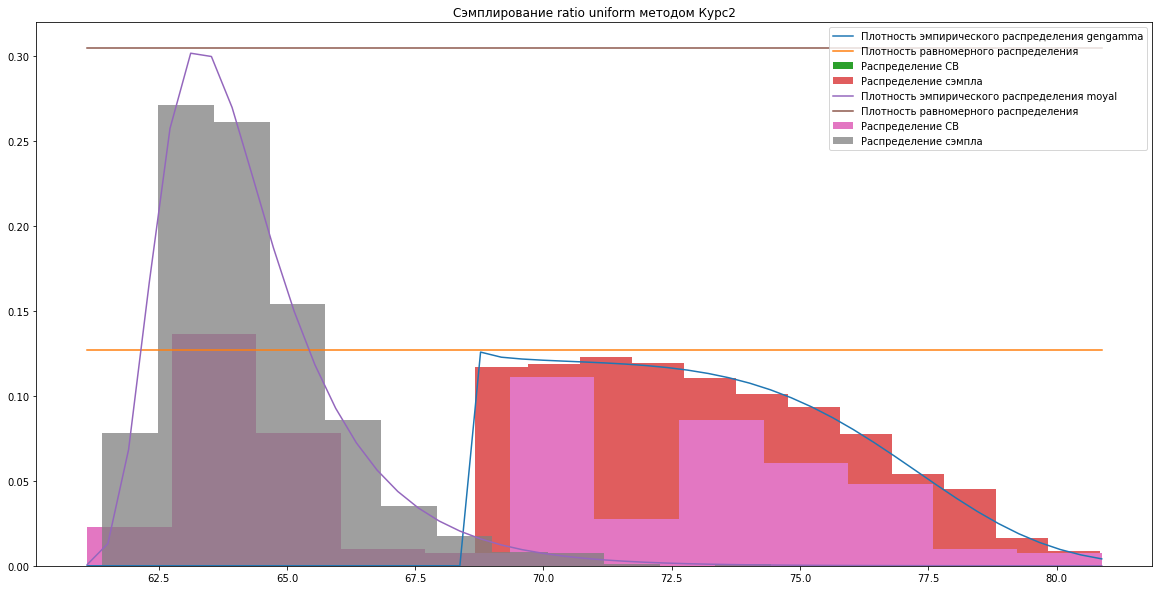

In [124]:
plt.figure(figsize=(20,10))
rejection_sampling(data, 'Курс2', 'gengamma', params20,12)
rejection_sampling(data, 'Курс2', 'moyal', params21,12)

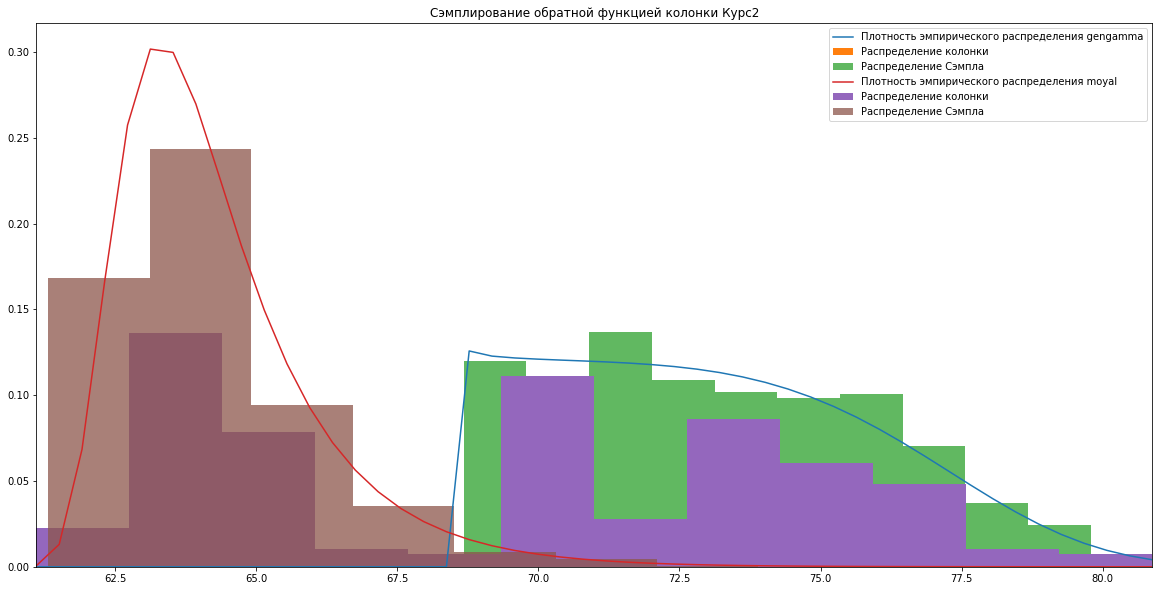

In [125]:
plt.figure(figsize=(20,10))
sampling(data, 'Курс2', 'gengamma', params20,12)
sampling(data, 'Курс2', 'moyal', params21,12)